In [ ]:
import dateutil.parser
import requests
import csv
import pandas
import math
import numpy as np

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import HTML
from newspaper import Article

In [ ]:
df = pandas.read_csv('bingACLEDNewsMatch.csv')
df = shuffle(df) 
training_limit = math.ceil(len(df) * 0.8)
validation_limit = len(df)- training_limit
i=0
training_data=[]
validation_data=[]
for index, row in df.iterrows():
    date_pub = dateutil.parser.parse(str(row['DatePublished']))
    if i <= training_limit:
        arr = [date_pub,row['Name'],row['Text'],row['Label'],row['Summary'],row['Keywords']]
        training_data.append(arr)
    else:
        arr = [date_pub,row['Name'],row['Text'],row['Label'],row['Summary'],row['Keywords']]
        validation_data.append(arr)
    i=i+1
    if i==1065:
        break

In [ ]:
def getLeadtime():
    count = 0
    dateValue = 0
    for index, row in df.iterrows():
        if row['DateLimit'] > 0 and row['DateLimit'] < 11:
            count=count+1
            dateValue = dateValue + row['DateLimit']
    return math.floor(dateValue/count)

In [ ]:
def getLabels(ip,op):
    for i in range(len(ip)):
        if ip[i][3] == 1.0:
            op.append(1)
        else:
            op.append(0)
    return op

In [ ]:
def getTextData(ip,op):
    for i in range(len(ip)):
        op.append(ip[i][5])
    return op

In [ ]:
print(len(training_data))
print(len(validation_data))
training_labels = []
validation_labels = []
validation_Features=[]
training_Features =[]

training_labels = getLabels(training_data,training_labels)
validation_labels = getLabels(validation_data,validation_labels)
training_Features = getTextData(training_data,training_Features)
validation_Features = getTextData(training_data,validation_Features)

whole_data = []
whole_labels = []
for index, row in df.iterrows():
    date_pub = dateutil.parser.parse(row['DatePublished'])
    arr = [date_pub,row['Name'],row['Text'],row['Label'],row['Summary'],row['Keywords']]
    if row['Keywords'] is np.nan:
        whole_data.append("")
    else:
        whole_data.append(row['Keywords'])
    if row['Label'] == 1.0:
        whole_labels.append(1)
    else:
        whole_labels.append(0)

853
212


In [ ]:
from sklearn import cross_validation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif
        
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(np.array(whole_data), np.array(whole_labels), test_size=0.1, random_state=42)
sample_art = ["SRINAGAR, India (AP) - Anti-India protests and clashes erupted in disputed Kashmir on Saturday after a gunbattle between militants and government forces killed four rebels, police and residents said.According to rights groups, they include at least 269 militants, 158 members of Indian government forces and 156 civilians.Indian troops early Saturday surrounded a southern village in the Pulwama area on a tip that militants were hiding there, leading to an exchange of gunfire, police said.Residents said government forces blasted one civilian house with explosives during the fighting, a common counterinsurgency tactic by Indian troops in Kashmir.Rebels have been fighting Indian control since 1989."]


### text vectorization--go from strings to lists of numbers
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
features_train_transformed = vectorizer.fit_transform(features_train)
features_test_transformed  = vectorizer.transform(features_test)
sample_article = vectorizer.transform(sample_art)

### feature selection, because text is super high dimensional and 
### can be really computationally chewy as a result
selector = SelectPercentile(f_classif, percentile=25)
selector.fit(features_train_transformed, labels_train)
features_train_transformed = selector.transform(features_train_transformed).toarray()
features_test_transformed  = selector.transform(features_test_transformed).toarray()
sample_article = selector.transform(sample_article).toarray()

/Users/dhayanidhigunasekaran/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(features_train_transformed, labels_train)

GaussianNB(priors=None)

In [ ]:
if clf.predict(sample_article) == 1:
    print("possiblity of event ")
else:
    print("No possibility of event")

possiblity of protests 


In [ ]:
print(getLeadtime())

5


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(features_train, labels_train)

y_pred = sgd.predict(features_test)

print('accuracy %s' % accuracy_score(y_pred, labels_test))

accuracy 0.8504672897196262


In [ ]:
my_tags = ['1','0']
print(classification_report(labels_test, y_pred,target_names=my_tags))

             precision    recall  f1-score   support

          1       0.92      0.80      0.85        59
          0       0.79      0.92      0.85        48

avg / total       0.86      0.85      0.85       107



In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(features_train, labels_train)

y_pred = logreg.predict(features_test)

print('accuracy %s' % accuracy_score(y_pred, labels_test))
print(classification_report(labels_test, y_pred,target_names=my_tags))

accuracy 0.8504672897196262
             precision    recall  f1-score   support

          1       0.89      0.83      0.86        59
          0       0.81      0.88      0.84        48

avg / total       0.85      0.85      0.85       107



In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(features_train, labels_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(features_test)

print('accuracy %s' % accuracy_score(y_pred, labels_test))
print(classification_report(labels_test, y_pred,target_names=my_tags))

accuracy 0.8317757009345794
             precision    recall  f1-score   support

          1       0.94      0.75      0.83        59
          0       0.75      0.94      0.83        48

avg / total       0.85      0.83      0.83       107



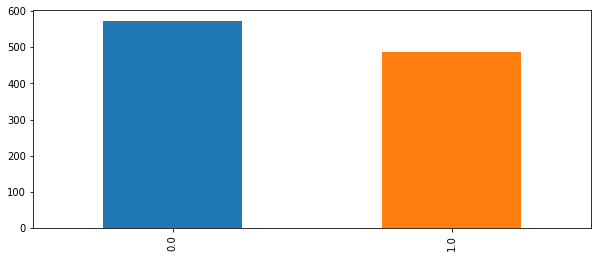

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
df.Label.value_counts().plot(kind='bar');